In [2]:
import os, sys
import math
import time
import shutil
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from IPython import display
from tensorflow.keras import datasets, layers, models

## Define Hyperparameters:

In [3]:
MODE = 'dcgan'       # Options are dcgan or wgan
DIM = 128           # Num of filters dimension
BATCH_SIZE = 32     # Training batch size
NUM_ITER = 90_001   # Total number of training iterations
NOISE_DIM = 128     # The dimension of noise input for the generator

# USED FOR WGAN ONLY:
CRITIC_RUNS = 5     # Num of critic train iter-ons per one generator iteration
CLIP_VAL = .1       # Weights clipping constant

## Load and Create the Dataset:

In [4]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteMLVRW7/fashion_mnist-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteMLVRW7/fashion_mnist-test.tfrecord


Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [5]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print(f"Number of training examples: {num_train_examples}")
print(f"Number of test examples:     {num_test_examples}")

Number of training examples: 60000
Number of test examples:     10000


In [6]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)
train_dataset = train_dataset.cache().repeat().batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

## Examine Some Images:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


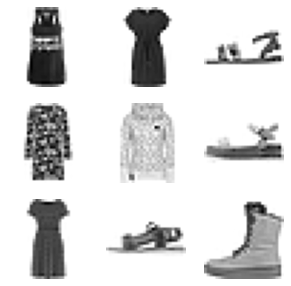

In [13]:
plt.figure(figsize=(5, 5))
for images, labels in train_dataset.take(6):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    my_image = images[i].numpy()
    plt.imshow(my_image[:,:,0], cmap='binary')
    plt.axis("off")

## Define Generator Model:

In [ ]:
def create_generator(name=None):
    model = tf.keras.Sequential(name=name)

    # First Layer:
    model.add(layers.Dense(7*7*4*DIM, use_bias=False, input_shape=(NOISE_DIM,)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Reshape((7, 7, 4*DIM)))
    assert model.output_shape == (None, 7, 7, 4*DIM)

    # Second Layer:
    model.add(layers.Conv2DTranspose(filters=2*DIM, 
                                     kernel_size=(5, 5),
                                     strides=(1, 1),
                                     padding='same', use_bias=True))
    assert model.output_shape == (None, 7, 7, 2*DIM)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # Third Layer:
    model.add(layers.Conv2DTranspose(filters=DIM, 
                                     kernel_size=(5, 5),
                                     strides=(2, 2),
                                     padding='same', use_bias=True))
    assert model.output_shape == (None, 14, 14, DIM)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # Fourth Layer:
    model.add(layers.Conv2DTranspose(filters=1, 
                                     kernel_size=(5, 5),
                                     strides=(2, 2),
                                     padding='same', use_bias=True))
    model.add(layers.Activation('tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

### Create and show fake image:

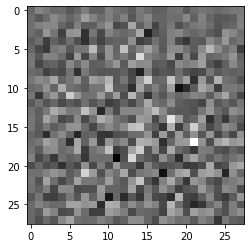

In [ ]:
generator = create_generator(name='Test')
noise = tf.random.normal([1, 128])
fake_image = generator(noise, training=False)
plt.imshow(fake_image[0, :, :, 0], cmap='binary')

## Define Discriminator Model:

We apply Batch Normalization for both the DCGAN and the WGAN weight clipping architectures:

In [ ]:
def create_discriminator(name=None):
    model = tf.keras.Sequential(name=name)

    # First Layer:
    model.add(layers.Conv2D(DIM, (5, 5), strides=(2, 2), padding='same',
                            input_shape=[28, 28, 1]))
    if MODE in ['dcgan', 'wgan']:
        model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second Layer:
    model.add(layers.Conv2D(2*DIM, (5, 5), strides=(2, 2), padding='same'))
    if MODE in ['dcgan', 'wgan']:
        model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Third Layer:
    model.add(layers.Conv2D(4*DIM, (5, 5), strides=(2, 2), padding='same'))
    if MODE in ['dcgan', 'wgan']:
        model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth Layer:
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = create_discriminator(name='Test')
decision = discriminator(fake_image)
print (decision)

tf.Tensor([[0.00013298]], shape=(1, 1), dtype=float32)


In [ ]:
for images, labels in train_dataset.take(1):
    decision = discriminator(images)
    print(decision[0])

tf.Tensor([0.01452998], shape=(1,), dtype=float32)


## Define Custom Losses and Optimizers:

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    if MODE == 'dcgan':
        # We want real pictures to be "flagged" as real --> close to ones:
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        # And the fake ones to be "flagged" as fake --> close to zeros:
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        return real_loss + fake_loss

    # In WGAN we just minimize Fake scores together with maximizing Real Scores:
    elif MODE == 'wgan':
        return tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)

def generator_loss(fake_output):
    # We want the generator to produce fakes that look like real --> close to ones!
    if MODE == 'dcgan':
        return cross_entropy(tf.ones_like(fake_output), fake_output)

    # In WGAN we just maximize Fake scores:
    elif MODE == 'wgan':
        return -tf.reduce_mean(fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)

## Training Steps Definition:

In [ ]:
@tf.function
def gen_train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape:
        generated_images = generator(noise, training=True)
        fake_output = discriminator(generated_images, training=True)        
        gen_loss = generator_loss(fake_output)
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)                           

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    return gen_loss

In [ ]:
@tf.function
def disc_train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        disc_loss = discriminator_loss(real_output, fake_output)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)                          

    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # Weights clipping for the discriminator in case WGAN is used:
    if MODE == 'wgan':
        for var in discriminator.trainable_variables:
            var.assign(tf.clip_by_value(var, -CLIP_VAL, CLIP_VAL))  

    return disc_loss

## Training Process Definition:

In [ ]:
try:
    shutil.rmtree(f'{MODE}')
except:
    pass
os.mkdir(f'{MODE}')
checkpoint_dir = f'{MODE}/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
def generate_and_save_images(generator, iteration, test_input):
  predictions = generator(test_input, training=False)
  fig = plt.figure(figsize=(8,8))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0], cmap='binary')
      plt.axis('off')

  plt.savefig(f'{MODE}/img_iter_{iteration:05}.png')
  plt.show()

In [ ]:
def train(dataset, test_dataset, num_iterations, seed):
    losses = {'gen_loss': [], 'disc_loss': [], 'test_disc_loss': []}
    start = time.time()
    iteration = 1

    for image_batch, labels in dataset:
        # Show initial grid for images:
        if iteration==1:
            disc_losses = []
            gen_losses = []
            generate_and_save_images(generator, iteration, seed)

        if MODE == 'wgan':
            for critic_run in range(CRITIC_RUNS):
                cur_disc_loss = disc_train_step(image_batch)
        elif MODE == 'dcgan':
            cur_disc_loss = disc_train_step(image_batch)

        cur_gen_loss = gen_train_step(image_batch)

        disc_losses.append(cur_disc_loss.numpy())
        gen_losses.append(cur_gen_loss.numpy())          

        # Save the models every 500 iterations and produce an images 4x4 grid:
        if iteration % 500 == 0:
            test_disc_losses = []
            '''
            for test_image_batch, labels in test_dataset:
                noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
                generated_images = generator(noise, training=False)
                real_output = discriminator(test_image_batch, training=False)
                fake_output = discriminator(generated_images, training=False)                
                test_disc_losses.append(discriminator_loss(real_output, fake_output))
            '''

            losses['disc_loss'].append(np.mean(disc_losses))
            losses['gen_loss'].append(np.mean(gen_losses))
            #losses['test_disc_loss'].append(np.mean(test_disc_losses))

            disc_losses = []
            gen_losses = []

            display.clear_output(wait=True)
            print(f'{iteration} of {num_iterations} iterations:')
            print(f'Loss: Generator: {round(losses["gen_loss"][-1], 2)}')
            print(f'Loss: Discriminator: {round(losses["disc_loss"][-1], 2)}')
            print(f'Elapsed Time: {round(time.time()-start, 2)} sec')
            checkpoint.save(file_prefix = checkpoint_prefix)
            generate_and_save_images(generator, iteration, seed)

        iteration += 1
        if iteration >= num_iterations:
            print("Training finished!")
            break

    return losses

90000 of 90001 iterations:
Loss: Generator: 4.980000019073486
Loss: Discriminator: 0.30000001192092896
Elapsed Time: 2566.98 sec


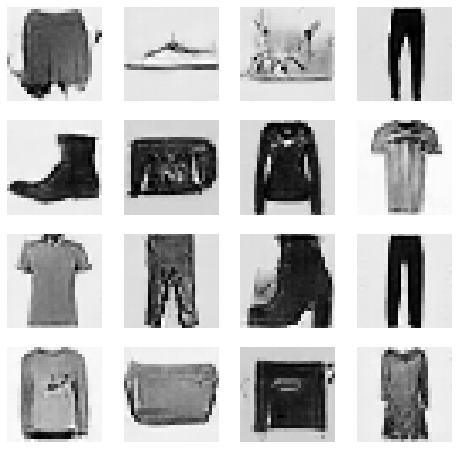

Training finished!
INFO:tensorflow:Assets written to: dcgan_model/assets


INFO:tensorflow:Assets written to: dcgan_model/assets


In [ ]:
seed = tf.random.normal([16, NOISE_DIM]) # So we can track the change
losses = train(train_dataset, test_dataset, NUM_ITER, seed)
generator.save(f"{MODE}_model")

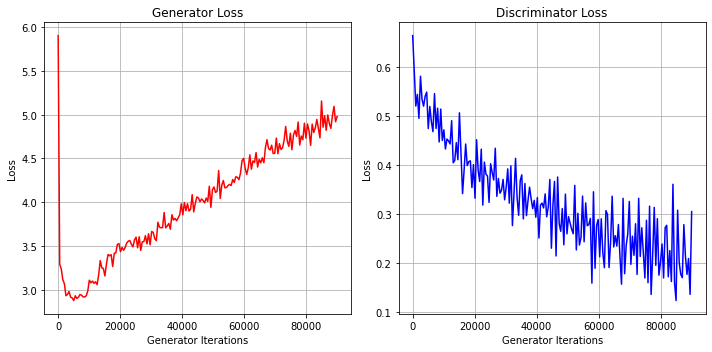

In [ ]:
%matplotlib inline
fig, ((ax1, ax2)) = plt.subplots(1, 2,figsize=(10,5))

ax1.plot(np.linspace(1, 500*len(losses['gen_loss']), len(losses['gen_loss'])),
         losses['gen_loss'], label = 'gen_loss', color='r')
ax1.set_title('Generator Loss')
ax1.grid(True)
ax1.set_xlabel('Generator Iterations')
ax1.set_ylabel('Loss')

ax2.plot(np.linspace(1, 500*len(losses['disc_loss']), len(losses['disc_loss'])),
         losses['disc_loss'], label = 'disc_loss', color='b')
ax2.set_title('Discriminator Loss')
ax2.grid(True)
ax2.set_xlabel('Generator Iterations')
ax2.set_ylabel('Loss')
'''
ax2.plot(np.linspace(1, 500*len(losses['test_disc_loss']), len(losses['test_disc_loss'])),
         losses['test_disc_loss'], label = 'test_disc_loss', color='c')
'''
fig.tight_layout()  

## Just for Fun: Animated GIF for training process:

In [ ]:
# To generate GIFs
! pip install -q imageio
! pip install -q git+https://github.com/tensorflow/docs

     |████████████████████████████████| 1.0MB 5.9MB/s 


In [ ]:
import tensorflow_docs.vis.embed as embed
import imageio
import glob

In [ ]:
anim_file = f'{MODE}.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob(f'{MODE}/img*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)

In [ ]:
embed.embed_file(f'{anim_file}')

Output hidden; open in https://colab.research.google.com to view.